In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.filterwarnings('ignore')
%matplotlib inline

In [41]:
car_df=pd.read_csv('data/out.csv')
#car_df.head()

In [42]:
# Rearrange the column
car_df=car_df[['price_range','price','cylinders','odometer','car_Age_in_yrs', 'manufacturer', 'model', 'fuel',
       'title_status', 'state', 'posting_date', 'drive_new',
       'condition_new', 'transmission_new', 'type_new', 'paint_color_new']]
# cat price range into 5 bins
car_df['price_range'] = pd.cut(x=car_df['price'], bins=[-1, 5000,9000,15000,24000,100000],
                               labels=['<5K','5K-9K','9K-15K','15K-24K','>24K'])
car_df['price_range'].unique()

['15K-24K', '>24K', '<5K', '5K-9K', '9K-15K']
Categories (5, object): ['<5K' < '5K-9K' < '9K-15K' < '15K-24K' < '>24K']

In [43]:
car_df['price_range']=np.where(car_df['price_range']=='<5K','veryLow',car_df['price_range'])
car_df['price_range']=np.where(car_df['price_range']=='5K-9K','low',car_df['price_range'])
car_df['price_range']=np.where(car_df['price_range']=='9K-15K','medium',car_df['price_range'])
car_df['price_range']=np.where(car_df['price_range']=='15K-24K','high',car_df['price_range'])
car_df['price_range']=np.where(car_df['price_range']=='>24K','veryHigh',car_df['price_range'])

In [44]:
car_df['price_range']=np.where(car_df['price_range']=='veryLow',0,car_df['price_range'])
car_df['price_range']=np.where(car_df['price_range']=='low',1,car_df['price_range'])
car_df['price_range']=np.where(car_df['price_range']=='medium',2,car_df['price_range'])
car_df['price_range']=np.where(car_df['price_range']=='high',3,car_df['price_range'])
car_df['price_range']=np.where(car_df['price_range']=='veryHigh',4,car_df['price_range'])

In [45]:
car_df['price_range']=[int(i) for i in car_df['price_range']]

In [46]:
car_df= car_df.drop(['posting_date','model','price'],axis=1)
car_df.info(verbose=bool)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137526 entries, 0 to 137525
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price_range       137526 non-null  int64  
 1   cylinders         137526 non-null  int64  
 2   odometer          137526 non-null  float64
 3   car_Age_in_yrs    137526 non-null  float64
 4   manufacturer      137526 non-null  object 
 5   fuel              137526 non-null  object 
 6   title_status      137526 non-null  object 
 7   state             137526 non-null  object 
 8   drive_new         137526 non-null  object 
 9   condition_new     137526 non-null  object 
 10  transmission_new  137526 non-null  object 
 11  type_new          137526 non-null  object 
 12  paint_color_new   137526 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 13.6+ MB


In [47]:
# One hot encoding
car_df1=pd.get_dummies(car_df[['price_range', 'manufacturer', 'cylinders', 'fuel', 'odometer',
       'title_status', 'state', 'drive_new', 'condition_new',
       'transmission_new', 'type_new', 'paint_color_new', 'car_Age_in_yrs']],drop_first=True)

# define X and y variables
X, y = car_df1.iloc[:, 1:].values, car_df1.iloc[:, 0].values

In [48]:
car_df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137526 entries, 0 to 137525
Data columns (total 122 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   price_range                   int64  
 1   cylinders                     int64  
 2   odometer                      float64
 3   car_Age_in_yrs                float64
 4   manufacturer_alfa-romeo       uint8  
 5   manufacturer_aston-martin     uint8  
 6   manufacturer_audi             uint8  
 7   manufacturer_bmw              uint8  
 8   manufacturer_buick            uint8  
 9   manufacturer_cadillac         uint8  
 10  manufacturer_chevrolet        uint8  
 11  manufacturer_chrysler         uint8  
 12  manufacturer_datsun           uint8  
 13  manufacturer_dodge            uint8  
 14  manufacturer_ferrari          uint8  
 15  manufacturer_fiat             uint8  
 16  manufacturer_ford             uint8  
 17  manufacturer_gmc              uint8  
 18  manufacturer_harley-dav

In [49]:
print(X.shape)
print(y.shape)

(137526, 121)
(137526,)


In [50]:
car_df1.shape

(137526, 122)

In [51]:
from sklearn.preprocessing import StandardScaler, normalize
# Scaling the data
sc=StandardScaler()
X_scaled=sc.fit_transform(X)
# Normalizing the data
X_normalized=normalize(X_scaled)
# Converting numpy array to pd dataframe
X_normalized=pd.DataFrame(X_normalized)

# Spectral Clustering

Memory error: full datasets, 30,0000 instances and 20,000 instances - "MemoryError: Unable to allocate 141. GiB for an array with shape (137526, 137526) and data type float64". 
10,000 instances has no issue on memory error.

In [52]:
# Random sample of 10,000 instances due to the memory error 
car_df_10k=car_df1.sample(n=10000, random_state=42)

In [53]:
X10k, y10k = car_df_10k.iloc[:, 1:].values, car_df_10k.iloc[:, 0].values

## Elbow curve on Spectral Clustering to find optimum number of cluster

In [54]:
# references: http://github.com/ciortanmadalina/high_noise_clustering/blob/master/spectral_clustering.ipynb

import scipy
from scipy.sparse import csgraph
# from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

In [55]:
# references: http://github.com/ciortanmadalina/high_noise_clustering/blob/master/spectral_clustering.ipynb

from scipy.spatial.distance import pdist, squareform
def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the number
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

Optimal number of clusters [ 270  790  867  903 1004]


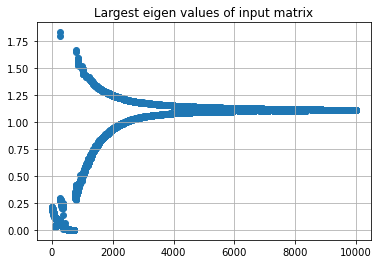

In [56]:
affinity_matrix = getAffinityMatrix(X10k, k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {k}')

In [57]:
from sklearn.preprocessing import StandardScaler, normalize
# Scaling the data
sc=StandardScaler()
X10k_scaled=sc.fit_transform(X10k)

# Normalizing the data
X10k_normalized=normalize(X10k_scaled)

# Converting numpy array to pd dataframe
X10k_normalized=pd.DataFrame(X10k_normalized)

In [58]:
# Dimensions reduction
from sklearn.decomposition import PCA
PCA=PCA(n_components=2)
X10k_PCA=PCA.fit_transform(X10k_normalized)
X10k_PCA=pd.DataFrame(X10k_PCA)
X10k_PCA.columns=['P1','P2']
X10k_PCA.head()

,P1,P2
0,0.557021,-0.089433
1,-0.234087,0.131318
2,-0.010067,-0.028834
3,-0.142454,-0.036614
4,0.305100,0.212441


In [59]:
X10k_PCA.shape

(10000, 2)

### Affinity Nearest Neighbors

In [60]:
%%time
from sklearn.cluster import SpectralClustering
spc_nn = SpectralClustering(n_clusters=765, affinity = 'nearest_neighbors',random_state=42)
labels_nn = spc_nn.fit_predict(X10k_PCA)

Wall time: 6min 44s


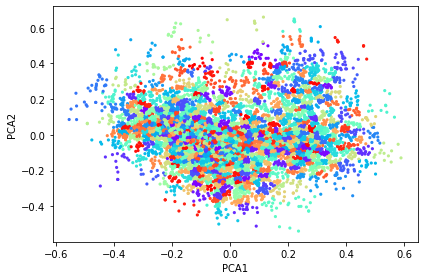

In [61]:
plt.scatter(x=X10k_PCA['P1'],y=X10k_PCA['P2'], c=labels_nn,cmap=plt.cm.rainbow, s=10, linewidths=0)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.show()

## Affinity Precomputed

In [63]:
%%time
from sklearn.neighbors import kneighbors_graph
Xknn = kneighbors_graph(X10k_PCA, 10)

spc_pre = SpectralClustering(n_clusters=765, affinity = 'precomputed',random_state=42)
labels_pre = spc_pre.fit_predict(Xknn)

Wall time: 6min 37s


In [64]:
pd.value_counts(labels_pre).head(10)

21     32
200    28
217    28
0      27
301    27
227    26
197    26
175    24
2      24
67     23
dtype: int64

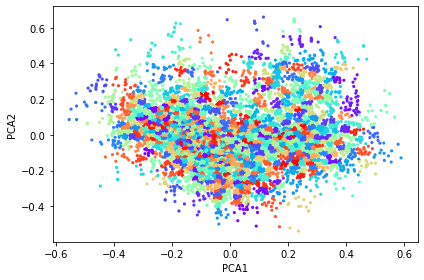

In [65]:
plt.scatter(x=X10k_PCA['P1'],y=X10k_PCA['P2'], c=labels_pre,cmap=plt.cm.rainbow, s=10, linewidths=0)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.show()

## Affinity rbf

In [66]:
%%time
spc_rbf = SpectralClustering(n_clusters=765,random_state=42)
labels_rbf = spc_rbf.fit_predict(X10k_PCA)

Wall time: 56min 27s


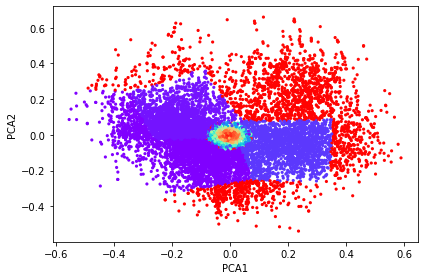

In [67]:
plt.scatter(x=X10k_PCA['P1'],y=X10k_PCA['P2'], c=labels_rbf,cmap=plt.cm.rainbow, s=10, linewidths=0)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.show()

In [68]:
from sklearn.metrics import silhouette_score

#List of different values of affinity
affinity=['precomputed','nearest_neighbors','rbf']
#List of Silhouette Scores
s_scores=[]
#Evaluating the performance
s_scores.append(silhouette_score(X10k_PCA, labels_nn))
s_scores.append(silhouette_score(X10k_PCA, labels_pre))
s_scores.append(silhouette_score(X10k_PCA, labels_rbf))
print(s_scores)

[0.3448857676519508, 0.342728130379158, -0.05138688173830967]


In [62]:

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier


cv = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
clf = RandomForestClassifier(n_estimators=150,random_state=42)


spc_nn = SpectralClustering(n_clusters=270, affinity = 'nearest_neighbors',random_state=42)
newfeature_nn = spc_nn.fit_predict(X10k)


X_spc = np.column_stack((X10k,pd.get_dummies(newfeature_nn)))

acc = cross_val_score(clf,X=X_spc,y=y10k,cv=cv)
#acc_origin=cross_val_score(clf,X=X10k,y=y10k,cv=cv)

print ("Average accuracy (with spectral clustering)= ", acc.mean()*100, "+-", acc.std()*100)
#print ("Average accuracy (without spectral clustering)= ", acc_origin.mean()*100, "+-", acc_origin.std()*100)

Average accuracy (with spectral clustering)=  70.69 +- 0.7435724578008528


In [23]:
print(X10k.shape)
print(X_spc.shape)
print(newfeature_nn.shape)

(10000, 124)
(10000, 889)
(10000,)


In [69]:
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
clf = RandomForestClassifier(n_estimators=150,random_state=42)


spc_nn = SpectralClustering(n_clusters=765, affinity = 'nearest_neighbors',random_state=42)
newfeature_nn = spc_nn.fit_predict(X10k)


X_spc = np.column_stack((X10k,pd.get_dummies(newfeature_nn)))

y10khat=np.zeros(y10k.shape)
for train, test in cv.split(X_spc,y10k):
    clf.fit(X_spc[train],y10k[train])
    y10khat[test]=clf.predict(X_spc[test])
    
total_accuracy  = mt.accuracy_score(y10k,y10khat)
total_precision = mt.precision_score(y10k,y10khat, average='weighted')
total_recall    = mt.recall_score(y10k,y10khat, average='weighted')
total_f1score   = mt.f1_score(y10k,y10khat, average='weighted')

print("Random Forest Accuracy", total_accuracy)
print("Random Forest Precision", total_precision)
print("Random Forest Recall", total_recall)
print("Random Forest f1 score", total_f1score)

Random Forest Accuracy 0.6997
Random Forest Precision 0.7009475966598544
Random Forest Recall 0.6997
Random Forest f1 score 0.6998721921675454


# KMeans

## Using elbow method to find the optimal number of clusters for Kmeans

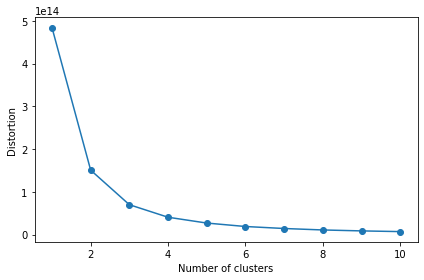

In [70]:
from sklearn.cluster import KMeans
distortions = []
X, y = car_df1.iloc[:, 1:].values, car_df1.iloc[:, 0].values
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=42)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

0.5697924359026937


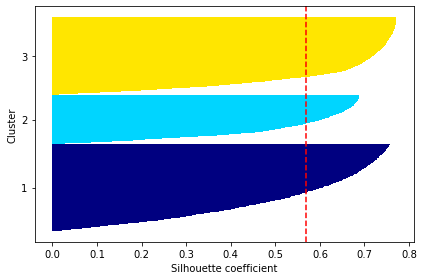

In [71]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=42)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
print(silhouette_avg)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('images/11_04.png', dpi=300)
plt.show()

In [72]:
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
clf = RandomForestClassifier(n_estimators=150,random_state=42)


cls = KMeans(n_clusters=3, init='k-means++',random_state=42)
cls.fit(X)
newfeature = cls.labels_ # the labels from kmeans clustering

X = np.column_stack((X,pd.get_dummies(newfeature)))


yhat=np.zeros(y.shape)
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test]=clf.predict(X[test])
    
total_accuracy  = mt.accuracy_score(y,yhat)
total_precision = mt.precision_score(y,yhat, average='weighted')
total_recall    = mt.recall_score(y,yhat, average='weighted')
total_f1score   = mt.f1_score(y,yhat, average='weighted')

print("Random Forest Accuracy", total_accuracy)
print("Random Forest Precision", total_precision)
print("Random Forest Recall", total_recall)
print("Random Forest f1 score", total_f1score)

Random Forest Accuracy 0.8205866527056702
Random Forest Precision 0.8207672174659707
Random Forest Recall 0.8205866527056702
Random Forest f1 score 0.820649865445795


# Agglomerative Clustering

In [76]:
%%time 

# Random sample of 5000 instances due to memory error.

from sklearn.cluster import AgglomerativeClustering

car_df_5k=car_df1.sample(n=5000, random_state=42)

n_fare=3
#cv = StratifiedKFold(n_splits=10)
cv = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
clf = RandomForestClassifier(n_estimators=150,random_state=42)

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(1,10):
        X5k, y5k = car_df_5k.iloc[:, 2:].values, car_df_5k.iloc[:, 1].values
        #X5k, y5k = car_df1.iloc[:, 1:].values, car_df1.iloc[:, 0].values
        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X5k)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering
      

        X = np.column_stack((X5k,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X=X,y=y5k,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print ("C=",n_fam,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

C= 1 ward Average accuracy =  74.17999999999999 +- 1.2048236385463236
C= 2 ward Average accuracy =  74.28 +- 1.4455448799674135
C= 3 ward Average accuracy =  74.15999999999998 +- 1.6728418933061202
C= 4 ward Average accuracy =  74.02 +- 1.395564401953562
C= 5 ward Average accuracy =  74.0 +- 1.8330302779823375
C= 6 ward Average accuracy =  73.92 +- 1.6154256405046954
C= 7 ward Average accuracy =  74.04 +- 1.3529227620230222
C= 8 ward Average accuracy =  74.18 +- 1.481755715359318
C= 9 ward Average accuracy =  74.03999999999999 +- 1.7726815844928288
C= 1 complete Average accuracy =  74.17999999999999 +- 1.2048236385463236
C= 2 complete Average accuracy =  74.4 +- 1.1027239001672187
C= 3 complete Average accuracy =  74.36 +- 1.3588230201170435
C= 4 complete Average accuracy =  74.20000000000002 +- 1.1865917579353071
C= 5 complete Average accuracy =  74.34 +- 1.3055267136294084
C= 6 complete Average accuracy =  73.92 +- 0.9474175425861618
C= 7 complete Average accuracy =  74.5000000000000

In [77]:
from sklearn.cluster import AgglomerativeClustering


ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(X5k)
print('Cluster labels: %s' % labels)

Cluster labels: [2 1 1 ... 2 2 1]


In [78]:


#cv = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
#clf = RandomForestClassifier(n_estimators=150,random_state=42)


# ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')

ac.fit(X5k)
newfeature=ac.labels_

X5k = np.column_stack((X5k,pd.get_dummies(newfeature)))


yhat=np.zeros(y5k.shape)

for train, test in cv.split(X5k,y5k):
    clf.fit(X5k[train],y5k[train])
    yhat[test]=clf.predict(X5k[test])
    
total_accuracy  = mt.accuracy_score(y5k,yhat)
total_precision = mt.precision_score(y5k,yhat, average='weighted')
total_recall    = mt.recall_score(y5k,yhat, average='weighted')
total_f1score   = mt.f1_score(y5k,yhat, average='weighted')

print("Random Forest Accuracy", total_accuracy)
print("Random Forest Precision", total_precision)
print("Random Forest Recall", total_recall)
print("Random Forest f1 score", total_f1score)

Random Forest Accuracy 0.7436
Random Forest Precision 0.737297418513372
Random Forest Recall 0.7436
Random Forest f1 score 0.7382799183836619


(4999, 4)


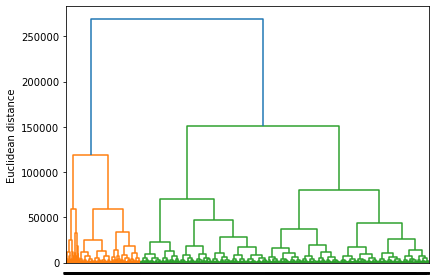

In [79]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist



row_clusters = linkage(pdist(car_df_5k, metric='euclidean'), method='complete')
print(row_clusters.shape)
# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, labels=labels)
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       
plt.tight_layout()
plt.ylabel('Euclidean distance')
#plt.savefig('images/11_11.png', dpi=300, 
#            bbox_inches='tight')
plt.show()

<ipython-input-35-d9e514a38de1>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axm.set_xticklabels([''] + list(df_rowclust.columns))
<ipython-input-35-d9e514a38de1>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axm.set_yticklabels([''] + list(df_rowclust.index))


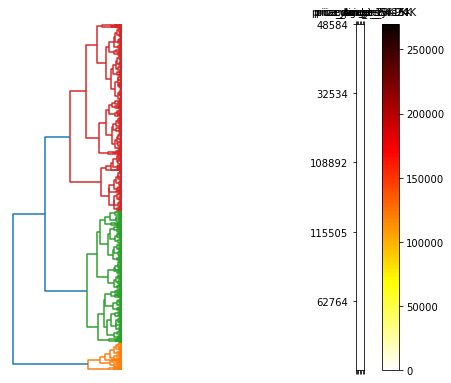

In [35]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = car_df_5k.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
    i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

#plt.savefig('images/11_12.png', dpi=300)
plt.show()

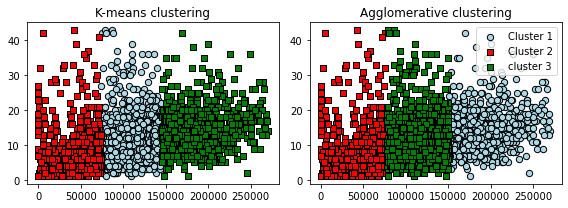

In [80]:
from sklearn.cluster import KMeans
#car_df_5k=car_df1.sample(n=5000, random_state=42)
#X2, y2 = car_df_5k.iloc[:, 2:].values, car_df_5k.iloc[:, 1].values

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

cls = KMeans(n_clusters=3, init='k-means++',random_state=42)
y_km = cls.fit_predict(X5k)

ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')

ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')

ax1.scatter(X[y_km == 2, 0], X[y_km == 2, 1],
            edgecolor='black',
            c='green', marker='s', s=40, label='cluster 3')

ax1.set_title('K-means clustering')


y_ac = labels
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='Cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='Cluster 2')
ax2.scatter(X[y_ac == 2, 0], X[y_ac == 2, 1],
            edgecolor='black',
            c='green', marker='s', s=40, label='cluster 3')

ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
#plt.savefig('images/11_15.png', dpi=300)
plt.show()

affinitystr or callable, default=’euclidean’
Metric used to compute the linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. 

If linkage is “ward”, only “euclidean” is accepted. 
If “precomputed”, a distance matrix (instead of a similarity matrix) is needed as input for the fit method.
**********
linkage{‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

‘ward’ minimizes the variance of the clusters being merged.

‘average’ uses the average of the distances of each observation of the two sets.

‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.

‘single’ uses the minimum of the distances between all observations of the two sets.

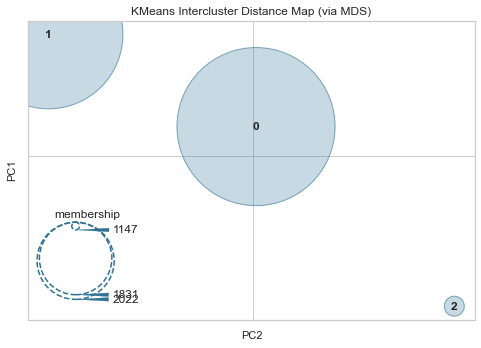

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [81]:
# Intercluster Distance from yellowbrick
from yellowbrick.cluster import InterclusterDistance
visualizer=InterclusterDistance(cls)
visualizer.fit(X)
visualizer.show()

TypeError: '<' not supported between instances of 'str' and 'int'

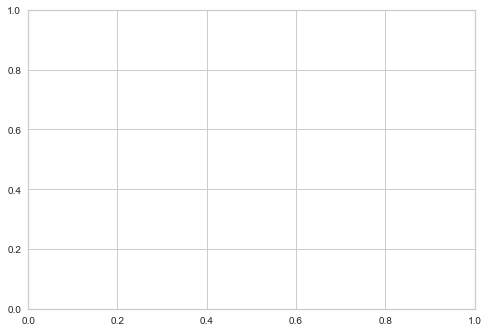

In [48]:

X, y = car_df1.iloc[:, 2:].values, car_df1.iloc[:, 1].values

from yellowbrick.model_selection import LearningCurve


# Instantiate the clustering model and visualizer
model = KMeans(n_clusters=3, init='k-means++',random_state=42)
visualizer = LearningCurve(model, random_state=42)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

## DBScan

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN

X=X_normalized
clf = RandomForestClassifier(n_estimators=150,random_state=42)
cv = StratifiedKFold(n_splits=10)

params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(5,8):

        # append on the clustering
        cls = DBSCAN(eps=eps, min_samples=mpts)
        cls.fit(X)
        newfeature_fam = cls.labels_ # the labels from kmeans clustering

        #y = df_imputed['Survived']
        #X = df_imputed[['IsMale','Pclass','Fare']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        #params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state
        print (eps,mpts,"Average accuracy = ", acc.mean()*100)
        #print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

0.1 5 Average accuracy =  68.79063347414137
